In [33]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import rarfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# 1. Data

In [9]:
# Define paths
rar_path = '/content/RANGE.rar'  # Update this path
extraction_path = 'extracted_data'

# Open and extract the RAR file
with rarfile.RarFile(rar_path) as images:
   images.extractall(extraction_path)

print("Extraction completed.")

Extraction completed.


In [11]:
# List contents of the extraction path to verify structure
extracted_content = os.listdir('extracted_data')
print("Extracted folder structure:", extracted_content)

Extracted folder structure: ['RANGE']


# 2.Set Image Parameters and Data Generators

In [13]:
# Image parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 10  # Adjust based on your compute power and dataset size

# Data augmentation and scaling
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.5, 1.5],
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Reserve 20% for validation
)

# Load the extracted training and validation data
train_data = train_datagen.flow_from_directory(
    'extracted_data',  # Update this if the folder structure is different
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_data = train_datagen.flow_from_directory(
    'extracted_data',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 130 images belonging to 1 classes.
Found 32 images belonging to 1 classes.


# 3. Define the VGG16 Model with Custom Layers

In [40]:
# Load VGG16 as base model
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg16_base.trainable = False  # Freeze base layers

# Add custom layers for VGG16
x = vgg16_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.05))(x)
x = Dropout(0.7)(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.05))(x)
x = Dropout(0.7)(x)
vgg16_predictions = Dense(train_data.num_classes, activation='softmax')(x)

# Compile the VGG16 model
vgg16_model = Model(inputs=vgg16_base.input, outputs=vgg16_predictions)
vgg16_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [41]:
# Set up Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 4. Define the ResNet50 Model with Custom Layers

In [42]:
# Load ResNet50 with pretrained weights
resnet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet50_base.trainable = False  # Freeze base layers

# Unfreeze the last few layers for fine-tuning
for layer in resnet50_base.layers[-3:]:  # Unfreeze the last 10 layers
    layer.trainable = True

# Add custom layers for ResNet50
y = resnet50_base.output
y = GlobalAveragePooling2D()(y)
y = Dense(512, activation='relu', kernel_regularizer=l2(0.05))(y)
y = BatchNormalization()(y)
y = Dropout(0.7)(y)
y = Dense(256, activation='relu', kernel_regularizer=l2(0.05))(y)
y = BatchNormalization()(y)
y = Dropout(0.7)(y)
resnet50_predictions = Dense(train_data.num_classes, activation='softmax')(y)

# Compile the ResNet50 model
resnet50_model = Model(inputs=resnet50_base.input, outputs=resnet50_predictions)
resnet50_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [43]:
# Set up Early Stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 5.Train Both Models and Track Metrics

In [44]:
# Train VGG16 Model
print("Training VGG16 model:")
vgg16_history = vgg16_model.fit(
    train_data,
    validation_data=validation_data,
    epochs=50,
    callbacks=[early_stopping]
)
print("VGG16 model training completed.")

Training VGG16 model:
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 109s 26s/step - accuracy: 1.0000 - loss: 42.4729 - val_accuracy: 1.0000 - val_loss: 41.9305
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 137s 20s/step - accuracy: 1.0000 - loss: 41.7727 - val_accuracy: 1.0000 - val_loss: 41.1545
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 143s 25s/step - accuracy: 1.0000 - loss: 40.9171 - val_accuracy: 1.0000 - val_loss: 40.3898
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 102s 20s/step - accuracy: 1.0000 - loss: 40.2366 - val_accuracy: 1.0000 - val_loss: 39.6368
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 143s 20s/step - accuracy: 1.0000 - loss: 39.4784 - val_accuracy: 1.0000 - val_loss: 38.8960
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 162s 30s/step - accuracy: 1.0000 - loss: 38.6697 - val_accuracy: 1.0000 - val_loss: 38.1674
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 102s 20s/step - accuracy: 1.0000 - loss: 38.0142 - val_accuracy: 1.0000 - val_loss: 37.4513
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 103s 20s/step - accuracy: 1.0000 - loss: 37.28

In [45]:
# Train ResNet50 Model
print("Training ResNet50 model:")
resnet50_history = resnet50_model.fit(
    train_data,
    validation_data=validation_data,
    epochs=50,
    callbacks=[early_stopping]
)
print("ResNet50 model training completed.")

Training ResNet50 model:
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 48s 7s/step - accuracy: 1.0000 - loss: 57.6103 - val_accuracy: 1.0000 - val_loss: 56.3985
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 36s 6s/step - accuracy: 1.0000 - loss: 56.0907 - val_accuracy: 1.0000 - val_loss: 54.8880
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 34s 6s/step - accuracy: 1.0000 - loss: 54.5331 - val_accuracy: 1.0000 - val_loss: 53.4108
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 41s 8s/step - accuracy: 1.0000 - loss: 52.9619 - val_accuracy: 1.0000 - val_loss: 51.9681
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 32s 6s/step - accuracy: 1.0000 - loss: 51.6811 - val_accuracy: 1.0000 - val_loss: 50.5607
ResNet50 model training completed.


# 6. Evaluate and Compare the Models

In [46]:
# Evaluate VGG16
vgg16_val_loss, vgg16_val_accuracy = vgg16_model.evaluate(validation_data)
print(f'VGG16 Validation Accuracy: {vgg16_val_accuracy:.2f}, Validation Loss: {vgg16_val_loss:.2f}')

# Evaluate ResNet50
resnet50_val_loss, resnet50_val_accuracy = resnet50_model.evaluate(validation_data)
print(f'ResNet50 Validation Accuracy: {resnet50_val_accuracy:.2f}, Validation Loss: {resnet50_val_loss:.2f}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - accuracy: 1.0000 - loss: 16.1648
VGG16 Validation Accuracy: 1.00, Validation Loss: 16.16
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 1.0000 - loss: 56.3985
ResNet50 Validation Accuracy: 1.00, Validation Loss: 56.40


# 7. Visualize Training and Validation Curves

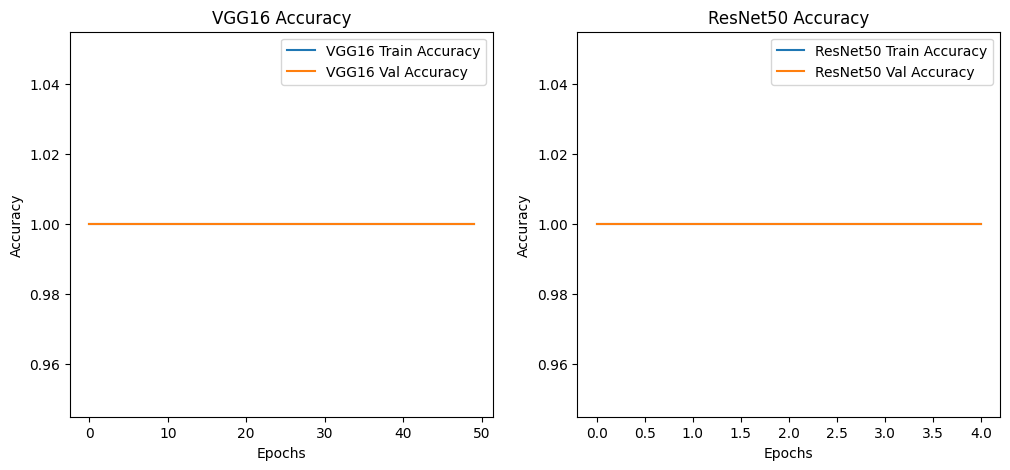

In [47]:
# Plot accuracy and loss for VGG16 and ResNet50
plt.figure(figsize=(12, 5))

# VGG16 accuracy
plt.subplot(1, 2, 1)
plt.plot(vgg16_history.history['accuracy'], label='VGG16 Train Accuracy')
plt.plot(vgg16_history.history['val_accuracy'], label='VGG16 Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('VGG16 Accuracy')

# ResNet50 accuracy
plt.subplot(1, 2, 2)
plt.plot(resnet50_history.history['accuracy'], label='ResNet50 Train Accuracy')
plt.plot(resnet50_history.history['val_accuracy'], label='ResNet50 Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('ResNet50 Accuracy')

plt.show()
